# Comparison of Segger vs. Baysor for Oversegmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from requirements import *
from segger.data.parquet._utils import (
    read_parquet_region,
    filter_transcripts,
    load_settings,
    get_polygons_from_xy,
)
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import *
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.utils import lighten_color
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from sg_utils.pl.plot_segmentation_comparison import *
from sg_utils.tl.generate_boundaries import generate_boundaries
from sg_utils.pl.plot_segmentation import *
import dask_geopandas as dgpd

## Callouts

### Main

In [175]:
# Region to plot
xmin, ymin, xmax, ymax = 5758, 15414, 5938, 15594
region = shapely.box(xmin, ymin, xmax, ymax)

In [290]:
# Read and filter membrane/DAPI image
image_filepath = data_dir / 'segmentation_image.npy'
image = np.load(image_filepath)
mpp = 0.2125 * 2
image = image[
    int(ymin / mpp): int(ymax / mpp),
    int(xmin / mpp): int(xmax / mpp),
]
mem = np.tile(image[:, :, 1, np.newaxis], (1, 1, 3)) * np.array([0, 1, 1])
nuc = np.tile(image[:, :, 0, np.newaxis], (1, 1, 3)) * np.array([1, 0, 0])
image = (mem + nuc).astype('uint8')

In [288]:
# Read and filter boundary polygons
bd_cellpose_filepath = data_dir / 'cellpose_mask_polygons.parquet'
bd_cellpose = gpd.read_parquet(bd_cellpose_filepath)
mask = bd_cellpose.within(region.buffer(20))
bd_cellpose = bd_cellpose[mask]

# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=['cellpose_cell_type', 'cellpose_cell_id'],
)
is_epithelial = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
transcripts['is_epithelial'] = is_epithelial

# Filter boundaries to epithelial
gb = transcripts.groupby('cellpose_cell_id')
mask = gb['is_epithelial'].mean().gt(0.33)
mask &= gb.size().gt(1)
mask = bd_cellpose.index.isin(mask.index[mask])
bd_cellpose = bd_cellpose[mask]

# Smooth pixelated outlines
bd_cellpose = bd_cellpose.buffer(2).buffer(-2)

100%|██████████| 370/370 [00:05<00:00, 68.14it/s] 


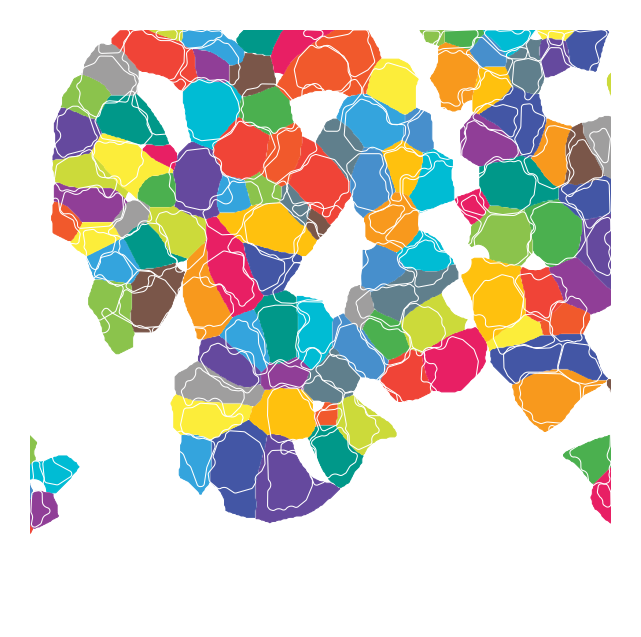

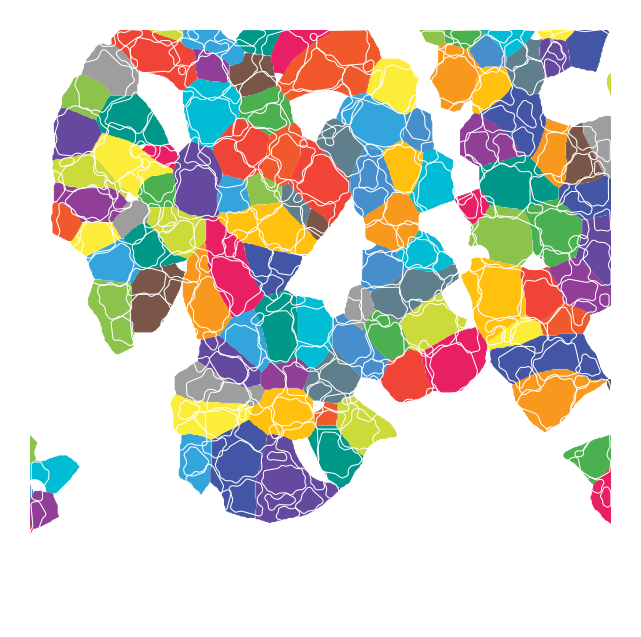

In [338]:
for seg_col in ['segger_cell_id_HDE46PBXJB', 'baysor_cell_id_c=0.5']:

    # Read and filter transcripts
    transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
    xe_settings = load_settings('xenium')
    transcripts = read_parquet_region(
        transcripts_filepath,
        *xe_settings.transcripts.xy,
        bounds=region,
        extra_columns=[seg_col, 'cellpose_cell_type', 'cellpose_cell_id'],
    )
    
    # Map epithelial label to transcripts
    is_epithelial = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
    transcripts['is_epithelial'] = is_epithelial
    
    # Generate boundaries
    bd_pred = generate_boundaries(
        transcripts,
        x='x_location',
        y='y_location',
        cell_id=seg_col,
    ).set_index('cell_id')
    
    # Filter boundaries to epithelial
    gb = transcripts.groupby(seg_col)
    mask = gb['is_epithelial'].mean().gt(0.33)
    mask &= gb.size().gt(1)
    mask = bd_pred.index.isin(mask.index[mask])
    bd_pred = bd_pred[mask]
    
    # Smooth boundaries
    bd_pred = bd_pred.simplify(0.5)
    bd_pred = bd_pred.buffer(2).buffer(-2).buffer(-1).buffer(1)
    
    # Plot IF images
    fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plot_segmentation_comparison(
        bd_cellpose,
        bd_pred,
        bd_true_kwargs=dict(facecolors=colors, edgecolors=colors, alpha=1),
        bd_pred_kwargs=dict(linewidths=0.25, facecolors=[0]*4),
        ax=ax,
        region=region,
        img=None,
        show_outlines=False,
    )
    ax.axis('off')  # remove ticks
    ax.set_facecolor([0]*4)
    
    fig.savefig(media_dir / f'oversegmentation_{seg_col}_outlines.svg')
    plt.close()

In [334]:
# Plot IF images
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_segmentation_comparison(
    bd_cellpose,
    bd_cellpose,
    bd_true_kwargs=dict(alpha=0.),
    bd_pred_kwargs=dict(linewidths=0.25, facecolors=[0]*4),
    ax=ax,
    region=region,
    img=None,
    show_outlines=True,
)
ax.axis('off')  # remove ticks
ax.set_facecolor([0]*4)

fig.savefig(media_dir / f'oversegmentation_cellpose_cell_id_outlines.svg')
plt.close()

In [336]:
# Plot IF images
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
plot_image(
    image=image,
    ax=ax,
    region=region,
)
ax.axis('off')  # remove ticks

fig.savefig(media_dir / f'oversegmentation_if_underlay.png', dpi=600)
plt.close()

### Supplementary

In [56]:
# Region to plot
i = 1
save = True
regions = [
    [1803, 12324, 1983, 12504],
    [5273, 15124, 5453, 15304],
]
xmin, ymin, xmax, ymax = regions[i]
region = shapely.box(xmin, ymin, xmax, ymax)
suffix = f'supp_{i+1}'

In [57]:
# Read and filter membrane/DAPI image
image_filepath = data_dir / 'segmentation_image.npy'
image = np.load(image_filepath)
mpp = 0.2125 * 2
image = image[
    int(ymin / mpp): int(ymax / mpp),
    int(xmin / mpp): int(xmax / mpp),
]
mem = np.tile(image[:, :, 1, np.newaxis], (1, 1, 3)) * np.array([0, 1, 1])
nuc = np.tile(image[:, :, 0, np.newaxis], (1, 1, 3)) * np.array([1, 0, 0])
image = (mem + nuc).astype('uint8')

In [58]:
# Read and filter boundary polygons
bd_cellpose_filepath = data_dir / 'cellpose_mask_polygons.parquet'
bd_cellpose = gpd.read_parquet(bd_cellpose_filepath)
mask = bd_cellpose.within(region.buffer(20))
bd_cellpose = bd_cellpose[mask]

# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
xe_settings = load_settings('xenium')
transcripts = read_parquet_region(
    transcripts_filepath,
    *xe_settings.transcripts.xy,
    bounds=region,
    extra_columns=['cellpose_cell_type', 'cellpose_cell_id'],
)
is_epithelial = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
transcripts['is_epithelial'] = is_epithelial

# Filter boundaries to epithelial
gb = transcripts.groupby('cellpose_cell_id')
mask = gb['is_epithelial'].mean().gt(0.33)
mask &= gb.size().gt(1)
mask = bd_cellpose.index.isin(mask.index[mask])
bd_cellpose = bd_cellpose[mask]

# Smooth pixelated outlines
bd_cellpose = bd_cellpose.buffer(2).buffer(-2)

In [59]:
for seg_col in ['segger_cell_id_HDE46PBXJB', 'baysor_cell_id_c=0.5']:

    # Read and filter transcripts
    transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
    xe_settings = load_settings('xenium')
    transcripts = read_parquet_region(
        transcripts_filepath,
        *xe_settings.transcripts.xy,
        bounds=region,
        extra_columns=[seg_col, 'cellpose_cell_type', 'cellpose_cell_id'],
    )
    
    # Map epithelial label to transcripts
    is_epithelial = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
    transcripts['is_epithelial'] = is_epithelial
    
    # Generate boundaries
    bd_pred = generate_boundaries(
        transcripts,
        x='x_location',
        y='y_location',
        cell_id=seg_col,
    ).set_index('cell_id')
    
    # Filter boundaries to epithelial
    gb = transcripts.groupby(seg_col)
    mask = gb['is_epithelial'].mean().gt(0.33)
    mask &= gb.size().gt(1)
    mask = bd_pred.index.isin(mask.index[mask])
    bd_pred = bd_pred[mask]
    
    # Smooth boundaries
    bd_pred = bd_pred.simplify(0.5)
    bd_pred = bd_pred.buffer(2).buffer(-2).buffer(-1).buffer(1)
    
    # Plot IF images
    fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plot_segmentation_comparison(
        bd_cellpose,
        bd_pred,
        bd_true_kwargs=dict(facecolors=colors, edgecolors=colors, alpha=1),
        bd_pred_kwargs=dict(linewidths=0.25, facecolors=[0]*4),
        ax=ax,
        region=region,
        img=None,
        show_outlines=False,
    )
    ax.axis('off')  # remove ticks
    ax.set_facecolor([0]*4)

    if save:
        fig.savefig(media_dir / f'oversegmentation_{seg_col}_outlines_{suffix}.svg')
        plt.close()

  4%|▍         | 8/181 [00:00<00:05, 29.17it/s]

A linearring requires at least 4 coordinates. [[1, 2]]


100%|██████████| 455/455 [00:06<00:00, 74.02it/s] 


In [60]:
# Plot IF images
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_segmentation_comparison(
    bd_cellpose,
    bd_cellpose,
    bd_true_kwargs=dict(alpha=0.),
    bd_pred_kwargs=dict(linewidths=0.25, facecolors=[0]*4),
    ax=ax,
    region=region,
    img=None,
    show_outlines=True,
)
ax.axis('off')  # remove ticks
ax.set_facecolor([0]*4)

if save:
    fig.savefig(media_dir / f'oversegmentation_cellpose_cell_id_outlines_{suffix}.svg')
    plt.close()

In [61]:
# Plot IF images
fig, ax = plt.subplots(1,1, figsize=(2.5, 2.5))
plot_image(
    image=image,
    ax=ax,
    region=region,
)
ax.axis('off')  # remove ticks

if save:
    fig.savefig(media_dir / f'oversegmentation_if_underlay_{suffix}.png', dpi=600)
    plt.close()

## Cell Sizes and Overlaps

In [3]:
segmentations = {
    '10x_cell_id': '10X',
    '10x_nucleus_id': '10X Nucleus',
    'segger_cell_id_3Q6EISGCD9': 'segger',
    'segger_cell_id_HDE46PBXJB': 'segger+',
    'baysor_cell_id_c=0.9': 'Baysor, c=0.9',
    'baysor_cell_id_c=0.7': 'Baysor, c=0.7',
    'baysor_cell_id_c=0.5': 'Baysor',
}

In [5]:
condensed_segmentations = [
    'Cellpose',
    '10X',
    '10X Nucleus',
    'segger+',
    'Baysor',
]

In [4]:
# Read and filter transcripts
transcripts_filepath = data_dir / 'labeled_transcripts.parquet'
xy = load_settings('xenium').transcripts.xy
columns = xy + list(segmentations.keys()) + [
    'cellpose_cell_type', 'cellpose_cell_id', 'segger_score_3Q6EISGCD9',
    'segger_score_HDE46PBXJB',
]
transcripts = pd.read_parquet(
    transcripts_filepath,
    columns=columns
)

# Map epithelial label to transcripts
is_epithelial = transcripts['cellpose_cell_type'].eq('Epithelial/Cancer')
transcripts['is_epithelial'] = is_epithelial

In [91]:
overlaps = []

for seg_col, name in tqdm(segmentations.items()):
    
    # Read into cuDF for faster operations
    columns = [seg_col, 'cellpose_cell_id', 'is_epithelial']
    if 'segger' in seg_col:
        columns.append(seg_col.replace('cell_id', 'score'))
    tx_cudf = cudf.from_pandas(transcripts[columns])
    
    # Get overlapping cells in epithelial Cellpose boundaries
    mask = tx_cudf['is_epithelial']
    if 'segger' in seg_col:
        mask &= tx_cudf[seg_col.replace('cell_id', 'score')].gt(0.5)
    counts = tx_cudf[mask].value_counts(['cellpose_cell_id', seg_col])
    idx = counts.index.get_level_values(1)
    if 'segger' in seg_col:
        mask = tx_cudf[seg_col.replace('cell_id', 'score')].gt(0.5)
        totals = tx_cudf.loc[mask, seg_col].value_counts().loc[idx]
    else:
        totals = tx_cudf[seg_col].value_counts().loc[idx]
    fracs = counts / totals.values
    df = (fracs.gt(1/4) & totals.gt(5).values).groupby('cellpose_cell_id').sum()

    # Label and add to list
    df = pd.DataFrame(df.to_pandas())
    df['segmentation'] = name
    overlaps.append(df)

# Join into DF and add CellPose for reference
overlaps = pd.concat(overlaps)
overlaps.loc[-1] = [1, 'Cellpose']

100%|██████████| 7/7 [00:38<00:00,  5.44s/it]


/tmp/ipykernel_25571/402570546.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


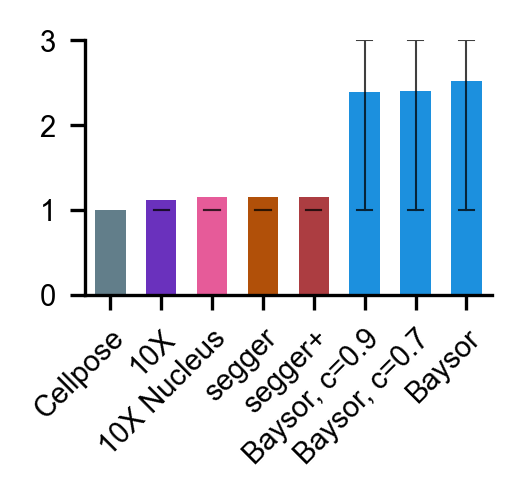

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.1))

order = ['Cellpose'] + list(segmentations.values())
palette = [to_rgba(named_colors[o]) for o in order]
styles = dict(saturation=0.9, capsize=0.3, width=0.6, palette=palette)

sns.barplot(
    overlaps,
    x='segmentation',
    y='count',
    errorbar=('pi', 50),
    order=order,
    err_kws=dict(linewidth=0.5, alpha=0.75, color='k'),
    ax=ax,
    **styles,
)
ax.tick_params(labelsize=7)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', va='top', rotation=45, rotation_mode="anchor")
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 3)
ax.set_yticks(range(4))
fig.savefig(media_dir / 'oversegmentation_cell_overlaps.svg')

/tmp/ipykernel_25571/1340047430.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


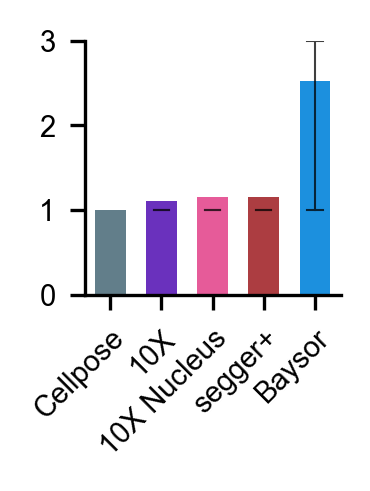

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(1.1, 1.1))

order = condensed_segmentations
palette = [to_rgba(named_colors[o]) for o in order]
styles = dict(saturation=0.9, capsize=0.3, width=0.6, palette=palette)

sns.barplot(
    overlaps[overlaps['segmentation'].isin(condensed_segmentations)],
    x='segmentation',
    y='count',
    errorbar=('pi', 50),
    order=order,
    err_kws=dict(linewidth=0.5, alpha=0.75, color='k'),
    ax=ax,
    **styles,
)
ax.tick_params(labelsize=7)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', va='top', rotation=45, rotation_mode="anchor")
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 3)
ax.set_yticks(range(4))
fig.savefig(media_dir / 'oversegmentation_cell_overlaps_condensed.svg')

In [6]:
segmentations.update({'cellpose_cell_id': 'Cellpose'})

In [7]:
areas = []

for seg_col, name in tqdm(segmentations.items()):
    
    # Transfer to cuDF for faster operations
    columns = [seg_col, 'is_epithelial'] + xy
    if 'segger' in seg_col:
        columns.append(seg_col.replace('cell_id', 'score'))
    tx_cudf = cudf.from_pandas(transcripts[columns])
    tx_cudf = tx_cudf.sort_values(seg_col)

    # Filter non-epithelial cells
    gb = tx_cudf.groupby(seg_col)
    mask = gb['is_epithelial'].mean().gt(0.33)
    mask &= gb.size().ge(10)
    mask = tx_cudf[seg_col].map(mask)
    if 'segger' in seg_col:
        mask &= tx_cudf[seg_col.replace('cell_id', 'score')].gt(0.5)
    tx_cudf = tx_cudf.loc[mask]

    # Convert to GeoSeries
    coords = tx_cudf[xy].values.get()
    indices = cudf.factorize(tx_cudf[seg_col])[0].get()
    multipts = shapely.multipoints(coords, indices)
    dgs = dgpd.from_geopandas(gpd.GeoSeries(multipts), npartitions=32)
    area = pd.DataFrame(dgs.convex_hull.area.compute(), columns=['area'])
    area['segmentation'] = name
    areas.append(area)

# Join into DF and add CellPose for reference
areas = pd.concat(areas)

100%|██████████| 8/8 [08:28<00:00, 63.58s/it]


/tmp/ipykernel_39933/3068286791.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


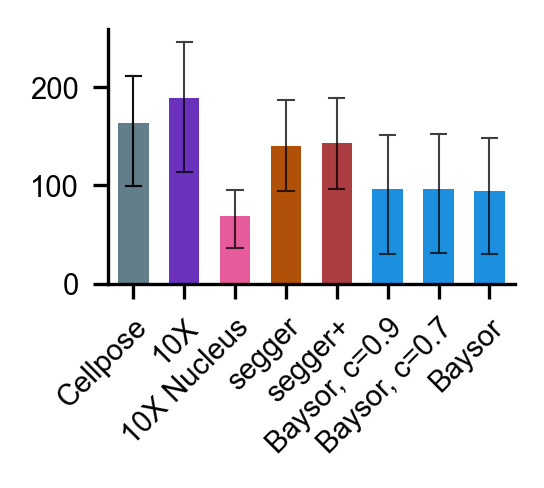

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.1))

order = ['Cellpose'] + list(segmentations.values())
palette = [to_rgba(named_colors[o]) for o in order]
styles = dict(saturation=0.9, capsize=0.3, width=0.6, palette=palette)

sns.barplot(
    areas,
    x='segmentation',
    y='area',
    errorbar=('pi', 50),
    order=order,
    err_kws=dict(linewidth=0.5, alpha=0.75, color='k'),
    ax=ax,
    **styles,
)
ax.tick_params(labelsize=7)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', va='top', rotation=45, rotation_mode="anchor")
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_ylim(0, 250)
#ax.set_yticks(range(0, 400, 100))
fig.savefig(media_dir / 'oversegmentation_cell_areas.svg')

/tmp/ipykernel_39933/2333024707.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


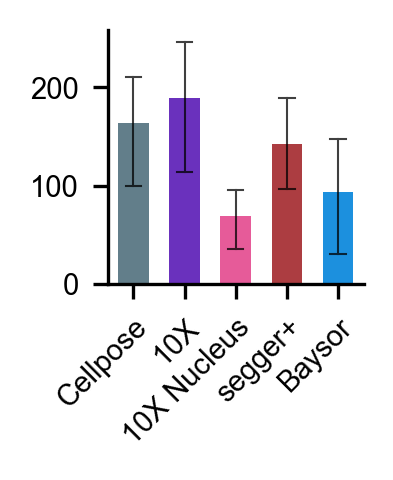

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(1.1, 1.1))

order = condensed_segmentations
palette = [to_rgba(named_colors[o]) for o in order]
styles = dict(saturation=0.9, capsize=0.3, width=0.6, palette=palette)

sns.barplot(
    areas[areas['segmentation'].isin(condensed_segmentations)],
    x='segmentation',
    y='area',
    errorbar=('pi', 50),
    order=order,
    err_kws=dict(linewidth=0.5, alpha=0.75, color='k'),
    ax=ax,
    **styles,
)
ax.tick_params(labelsize=7)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', va='top', rotation=45, rotation_mode="anchor")
ax.set_xlabel('')
ax.set_ylabel('')
fig.savefig(media_dir / 'oversegmentation_cell_areas_condensed.svg')

## Load in AnnDatas

In [3]:
# Segmentation columns to compare
segmentations = {
    'cellpose_cell_id': 'Cellpose',
    '10x_cell_id': '10X',
    '10x_nucleus_id': '10X Nucleus',
    'baysor_cell_id_c=0.5': 'Baysor, c=0.5',
    #'baysor_cell_id_c=0.7': 'Baysor, c=0.7',
    #'baysor_cell_id_c=0.9': 'Baysor, c=0.9',
    #'segger_cell_id_3Q6EISGCD9': 'Segger',
    'segger_cell_id_HDE46PBXJB': 'Segger+',
}

## Intermediate Populations

### Histograms of Cell UMI Counts

In [22]:
# Cutoff of cells below IQR
iqr_cutoff = 0.25

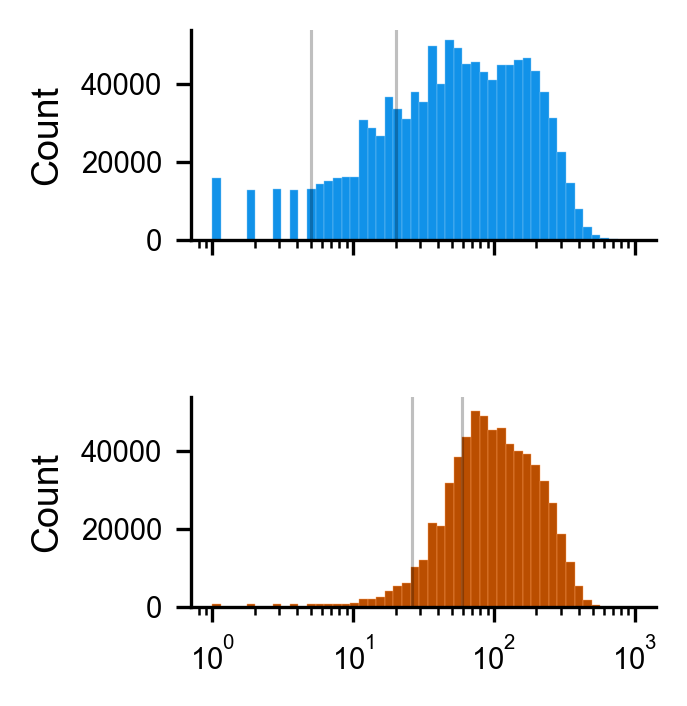

In [28]:
fig, axes = plt.subplots(
    2, 1, figsize=(2, 2.5), 
    gridspec_kw=dict(hspace=0.75),
    sharex=True, sharey=True,
)

colors = [named_colors['Baysor, c=0.5'], named_colors['segger']]

for ax, ad, color in zip(axes.flat, [ad_bay, ad_seg], colors):  
    counts = ad.uns['raw_counts']['count']  # unfiltered counts
    
    sns.histplot(
        data=counts,
        bins=np.linspace(0, 3, 50),
        facecolor=color,
        edgecolor=lighten_color(color, 0.5),
        linewidth=0.1,
        log_scale=(True, False),
        ax=ax,
    )
    # Draw filtering and IQR cutoffs
    for q in [0.05, iqr_cutoff]:
        ax.axvline(np.quantile(counts, q), lw=0.75, color='k', alpha=0.25)

#fig.savefig(media_dir / 'oversegmentation_umi_histograms.svg')

### Violin Plots of Cell Entropies by UMI Counts

In [8]:
# Add column to plot
for ad in [ad_bay, ad_seg]:
    bin_edges = np.quantile(ad.uns['raw_counts']['count'], [0, iqr_cutoff, 1])
    ad.obs['counts_group'] = pd.cut(ad.obs['n_counts'], bins=bin_edges)

In [9]:
# Corresponding palette
colors = sns.color_palette('tab20')
palette = [colors[0], colors[-1]]

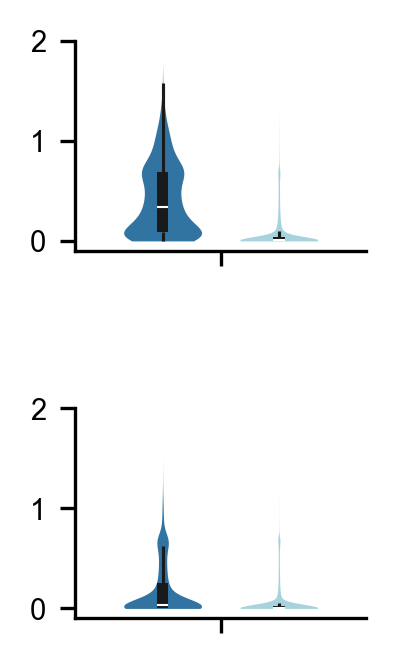

In [10]:
fig, axes = plt.subplots(
    2, 1, figsize=(1.25, 2.5), 
    gridspec_kw=dict(hspace=0.75),
    sharex=False, sharey=True,
)

for ax, ad in zip(axes.flat, [ad_bay, ad_seg]):
    flierprops = dict(
        markersize=1,
        markeredgewidth=0,
        markerfacecolor='gray',
        alpha=0.01,
    )
    sns.violinplot(
        data=ad.obs,
        hue='counts_group',
        y='celltypist_entropy',
        ax=ax,
        palette=palette,
        legend=False,
        gap=0.33,
        linewidth=0,
        bw_adjust=3,
        cut=0,
    )
    sns.boxplot(
        data=ad.obs,
        hue='counts_group',
        y='celltypist_entropy',
        ax=ax,
        palette=palette,
        legend=False,
        gap=0.9,
        boxprops=dict(linewidth=0, facecolor=[0.1]*3),
        whiskerprops=dict(linewidth=0.75, color=[0.1]*3),
        capprops=dict(linewidth=0),
        medianprops=dict(linewidth=0.5, color='w'),
        showfliers=False,
    )
    ax.set_ylabel('')
    ax.set_ylim(-0.1, 2)

fig.savefig(media_dir / 'oversegmentation_cell_type_entropy_violins.svg')

### UMAPs of Low vs. High UMIs

In [11]:
# Clip to ignore outliers
lbl = 'celltypist_label'
col = 'celltypist_entropy'
vmin = min(ad_bay.obs[col].quantile(0.001), ad_seg.obs[col].quantile(0.001))
vmax = min(ad_bay.obs[col].quantile(0.99), ad_seg.obs[col].quantile(0.99))

# Create continuous labeling
categories = set(ad_bay.obs[lbl].unique()).union(ad_seg.obs[lbl].unique())
mapping = {k: v * 2 for v, k in enumerate(categories)}
new_col = 'continuous_label'

ad_bay.obs[new_col] = ad_bay.obs[lbl].map(mapping).astype(float)
vals = (ad_bay.obs[col].clip(vmin, vmax) - vmin) / (vmax - vmin)
ad_bay.obs[new_col] += vals
ad_bay.obs[new_col] /= len(categories) * 2 - 1

ad_seg.obs[new_col] = ad_seg.obs[lbl].map(mapping).astype(float)
vals = (ad_seg.obs[col].clip(vmin, vmax) - vmin) / (vmax - vmin)
ad_seg.obs[new_col] += vals
ad_seg.obs[new_col] /= len(categories) * 2 - 1

# Create corresponding colormap
colors = [c for cat in categories for c in (named_colors[cat], 'lightgray')]
cmap = LinearSegmentedColormap.from_list('', colors, 255)

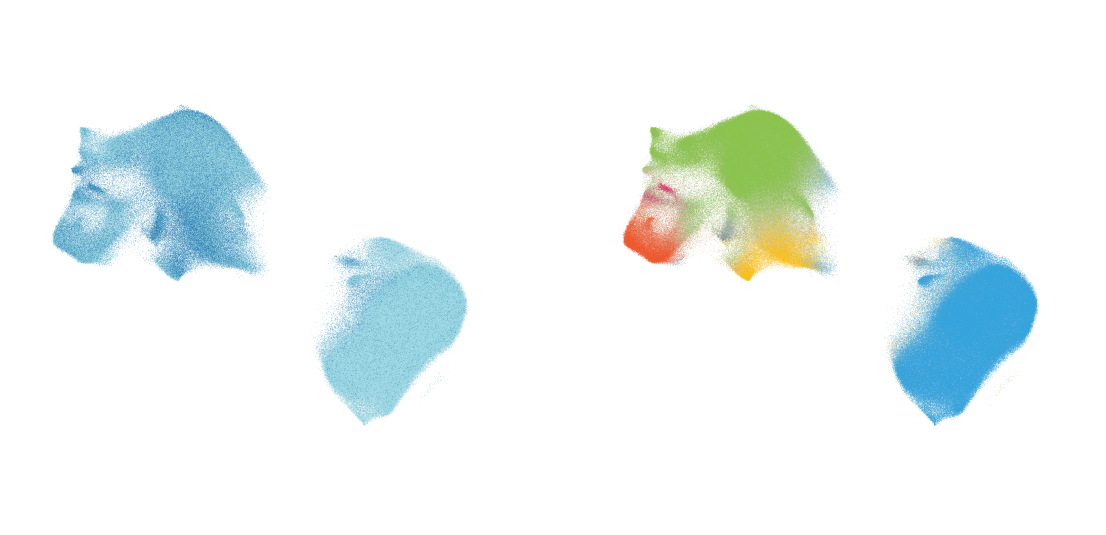

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(4.5, 2.25))

styles = dict(
    s=0.05, sort_order=False, legend_loc='', colorbar_loc=None,
    rasterized=True,
)
# UMI count group
_ = plot_embedding(ad_seg, 'counts_group', ax=axes[0], palette=palette, **styles)
# Cell type labels
_ = plot_embedding(ad_seg, new_col, cmap=cmap, ax=axes[1], **styles)
for ax in axes:
    ax.set_title('')

fig.savefig(media_dir / 'oversegmentation_segger_umaps.svg', dpi=600)

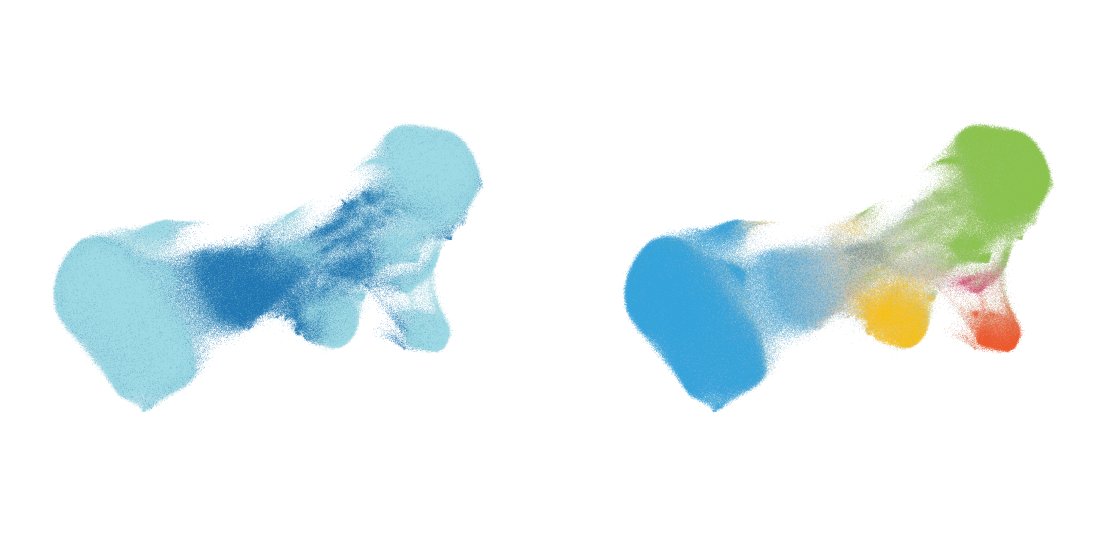

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(4.5, 2.25))

styles = dict(
    s=0.05, sort_order=False, legend_loc='', colorbar_loc=None,
    rasterized=True,
)
# UMI count group
_ = plot_embedding(ad_bay, 'counts_group', ax=axes[0], palette=palette, **styles)
# Cell type labels
_ = plot_embedding(ad_bay, new_col, cmap=cmap, ax=axes[1], **styles)
for ax in axes:
    ax.set_title('')

fig.savefig(media_dir / 'oversegmentation_baysor_umaps.svg', dpi=600)

## Cell Type Proportions

### Overall

In [15]:
counts = pd.DataFrame(
    index=['Cellpose', 'Segger+', 'Baysor, c=0.5'],
    dtype=float,
)
for name, ad in zip(counts.index, [ad_cps, ad_seg, ad_bay]):
    mask = ad.obs['celltypist_probability'].ge(0.5)
    vals = ad.obs[mask].value_counts('celltypist_label')
    counts.loc[name, vals.index] = vals

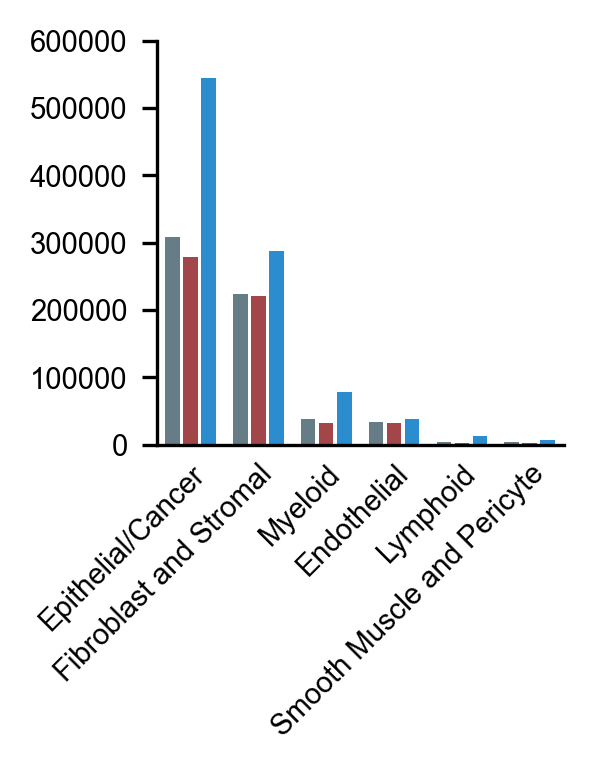

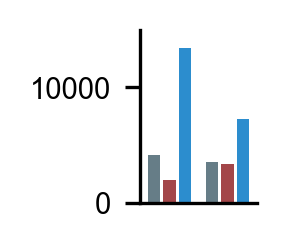

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.75))
kwargs = dict(x='variable', hue='seg', y='value', gap=0.2, palette=named_colors)
df = counts.copy()
df['seg'] = df.index
df = df.melt(id_vars=['seg'])
sns.barplot(df, ax=ax, legend=False, **kwargs)
ax.set_ylim(0, 600000)
ax.tick_params(axis='x', length=0)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', va='top', rotation=45, rotation_mode="anchor")
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig(media_dir / 'oversegmentation_cell_type_proportions.svg')

fig, ax_inset = plt.subplots(1, 1, figsize=(0.5, 0.75))
mask = df['variable'].isin(['Lymphoid', 'Smooth Muscle and Pericyte'])
sns.barplot(df[mask], ax=ax_inset, legend=False, **kwargs)
ax_inset.set_ylim(0, 15000)
ax_inset.set_ylabel('')
ax_inset.xaxis.set_visible(False)
fig.savefig(media_dir / 'oversegmentation_cell_type_proportions_inset.svg')

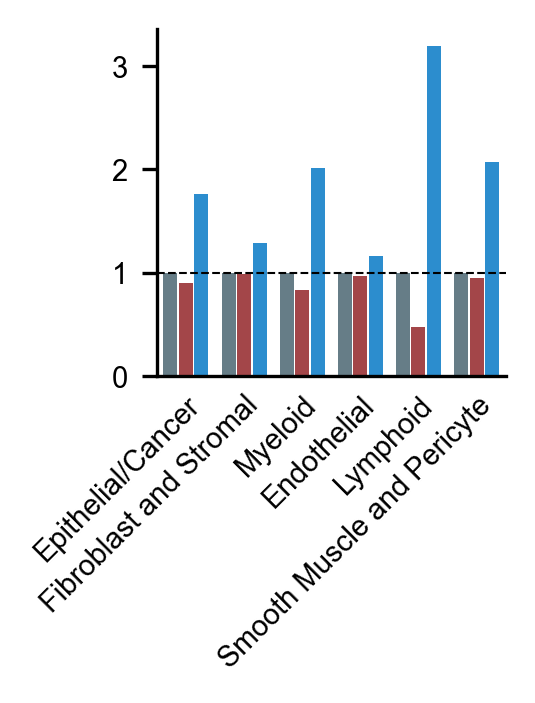

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

# Prepare data
df = counts.divide(counts.loc['Cellpose'], axis=1)#.drop('Cellpose', axis=0)
df['seg'] = df.index
df = df.melt(id_vars=['seg'])

kwargs = dict(x='variable', hue='seg', y='value', gap=0.1, palette=named_colors)
sns.barplot(df, ax=ax, legend=False, **kwargs)
ax.tick_params(axis='x', length=0)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', va='top', rotation=45, rotation_mode="anchor")
ax.set_ylabel('')
ax.set_xlabel('')
ax.axhline(1, lw=0.5, color='k', linestyle='--')
fig.savefig(media_dir / 'oversegmentation_relative_cell_type_proportions.svg')

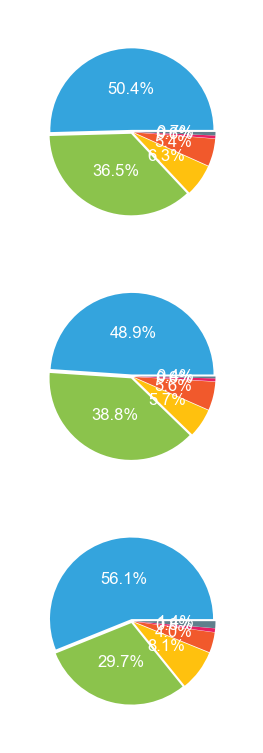

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(1, 3))

order = [
    'Epithelial/Cancer',
    'Fibroblast and Stromal',
    'Myeloid',
    'Endothelial',
    'Smooth Muscle and Pericyte',
    'Lymphoid'
]

for ax, ad in zip(axes.flat, [ad_cps, ad_seg, ad_bay]):
    mask = ad.obs['celltypist_probability'].ge(0.5)
    fracs = ad.obs[mask].value_counts('celltypist_label') / mask.sum()
    ax.pie(
        fracs.loc[order],
        colors=[named_colors[c] for c in order],
        explode=[0.025] * len(order),
        autopct='%1.1f%%',
        pctdistance=0.5,
        textprops=dict(size=4, color='w')
    )

fig.savefig(media_dir / 'oversegmentation_cell_type_pie_charts.svg')

### By Neighbors

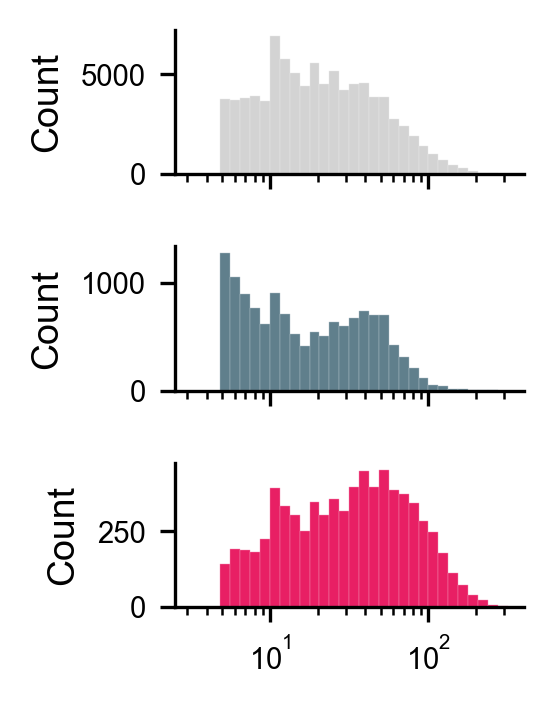

In [60]:
fig, axes = plt.subplots(
    3, 1, figsize=(1.5, 2.5), 
    gridspec_kw=dict(hspace=0.5),
    sharex=True,
)
kwargs = dict(linewidth=0.1, log_scale=(True,False), bins=np.linspace(0.5, 2.5, 33))
mask = ad_bay.obs['celltypist_probability'].ge(0.5)
masks = [
    ad_bay.obs['celltypist_entropy'].lt(0.5),
    (ad_bay.obs['celltypist_label'].eq('Lymphoid') & mask),
    (ad_bay.obs['celltypist_label'].eq('Smooth Muscle and Pericyte') & mask)
]
colors = [
    'lightgray',
    named_colors['Lymphoid'],
    named_colors['Smooth Muscle and Pericyte'],
]

for ax, mask, color in zip(axes.flat, masks, colors):
    sns.histplot(
        ad_bay.obs.loc[mask, 'n_counts'],
        facecolor=color,
        edgecolor=lighten_color(color, 0.5),
        ax=ax,
        **kwargs,
    )
    ax.set_xlabel('')

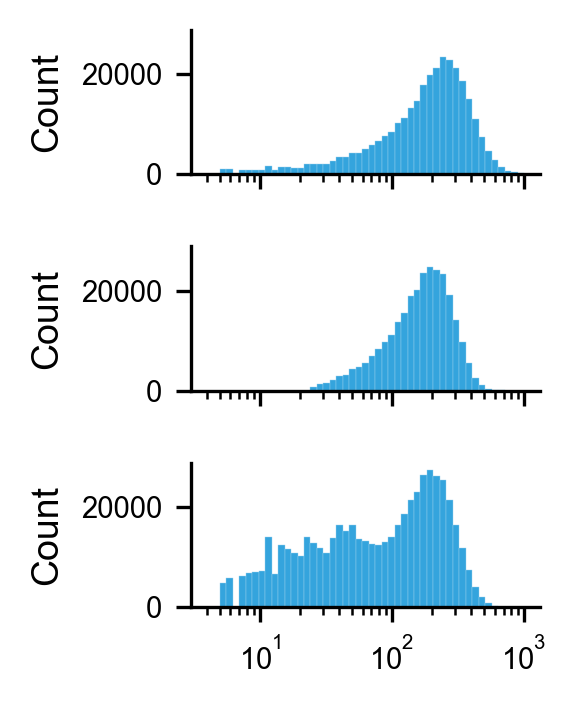

In [22]:
fig, axes = plt.subplots(
    3, 1, figsize=(1.5, 2.5), 
    gridspec_kw=dict(hspace=0.5),
    sharex=True, sharey=True,
)

color = named_colors['Epithelial/Cancer']

for ax, ad in zip(axes.flat, [ad_cps, ad_seg, ad_bay]):  
    sns.histplot(
        data=ad.obs[
            ad.obs['celltypist_label'].eq('Epithelial/Cancer') &
            ad.obs['celltypist_probability'].ge(0.5)
        ],
        x='n_counts',
        bins=np.linspace(0.6, 3, 50),
        facecolor=color,
        edgecolor=lighten_color(color, 0.5),
        linewidth=0.1,
        log_scale=(True, False),
        ax=ax,
    )
    ax.set_xlabel('')

fig.savefig(media_dir / 'oversegmentation_epithelial_umi_histograms.svg')

In [15]:
# Add kNN graph with wider k search
k = 50
dfs = []
names = ['Cellpose', 'Segger+', 'Baysor, c=0.5']

for name, ad in zip(names, [ad_cps, ad_seg, ad_bay]):

    # Recompute kNN on space
    X = cp.array(ad.obsm['X_spatial'])
    model = cuml.neighbors.NearestNeighbors(n_neighbors=k)
    model.fit(X)
    distances, indices = model.kneighbors(X)
    #indices[distances > max_dist] = -1

    # Get cell type proportions among neighbors
    labels, names = pd.factorize(ad.obs['celltypist_label'])
    values = ad[:, 'CDH1'].layers['lognorm'].todense().A.T[0]
    mask = ad.obs['celltypist_label'].eq('Epithelial/Cancer')
    neighbors = np.zeros((mask.sum(), len(names)))

    for i, row in tqdm(enumerate(indices[mask].get())):
        idx, counts = np.unique(labels[row[row != -1]], return_counts=True)
        neighbors[i, idx] = counts / k
    
    df = pd.DataFrame(neighbors, columns=names)
    df['segmentation'] = name
    dfs.append(df)

df = pd.concat(dfs).melt(id_vars='segmentation')

320287it [00:09, 34226.79it/s]
286114it [00:08, 34270.20it/s]
565852it [00:17, 32979.59it/s]


In [34]:
fracs = df.groupby(['segmentation', 'variable'])['value'].mean().unstack()
fracs = fracs.loc[
    ['Cellpose', 'Segger+', 'Baysor, c=0.5'],
    fracs.sum(0).sort_values(ascending=False).index,
]

In [69]:
fracs

variable,Epithelial/Cancer,Fibroblast and Stromal,Myeloid,Endothelial,Lymphoid,Smooth Muscle and Pericyte
segmentation,,,,,,
Cellpose,0.686911,0.225875,0.051873,0.026053,0.006298,0.002990
Segger+,0.678753,0.239368,0.049087,0.026669,0.004407,0.001716
"Baysor, c=0.5",0.738350,0.156215,0.063841,0.018594,0.017136,0.005864


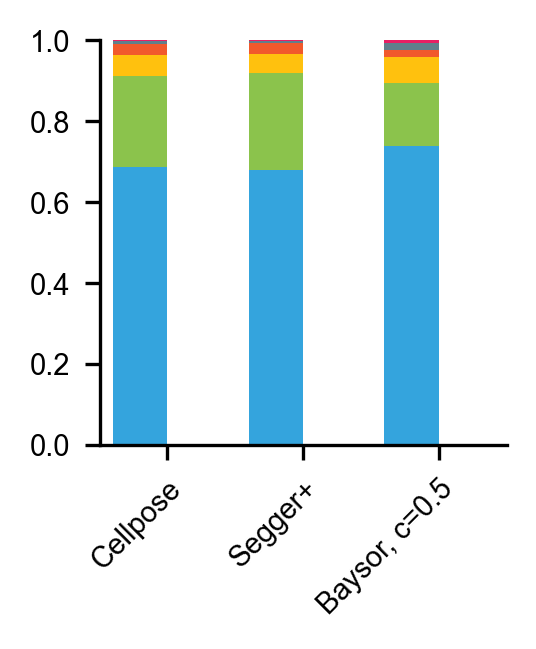

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.75))

fracs.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=-0.4,
    align='edge',
    color=named_colors,
    legend=False,
)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 1)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', va='top', rotation=45, rotation_mode="anchor")
ax.set_xlabel('')
fig.savefig(media_dir / 'oversegmentation_neighbor_proportions.svg')